In [1]:
#Here all the needed imports are done. Below the main programms filepath it added to the systempath.
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import Pauli, pauli_basis
from qiskit_aer.noise import NoiseModel, pauli_error
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from random import choice, choices, random
from scipy.optimize import curve_fit
import math

# This adds the systempath for the "pauli_lindblad_per" folder to the notebook. If the folderstructure is changed, this line needs to be adjusted accordingly
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))
# Import the Tomography header
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

In [2]:
#The number of qubits in our system is set
num_qubits = 4
#With that number a coupling map is created. It can be choosen to be whatever desired. 
#Right now is does a linear coupling map with connections forwards [0,1](first bracket) and backwards [1,0](last bracket). 
#The implementation of the linear coupling here is flexable to work with any qubit count
coupling_map = [[i,i+1] for i in range(num_qubits-1)]+[[i+1,i] for i in range(num_qubits-1)] 
#This is then used to create the backend
backend = GenericBackendV2(num_qubits=num_qubits, coupling_map=coupling_map)

In [3]:
twoqubit_errorops = [Pauli('YX')] 
# The respective chance for the Pauli errors is choosen. The two lists need to be equal in length
twoqubit_errorprobs = [0.05] 
# Create *normalized* error model.
twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
twoqubit_error = pauli_error(twoqubit_error_template)

noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

In [4]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1 
J = -.15
dt = .2 # time stepsize
n = 2 # amount of qubits halfed

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend) # transpiling swaps gates for backend native gates and optimizes the code by removing and combining unnessesary gates
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]
circuits[0].draw(fold=-1)

┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐                                             ░ 
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.9416) ├┤ √X ├┤ Rz(5π/2) ├──■────────────────■─────────────────────────░─
         ├─────────┤├────┤├────────────┤├────┤├──────────┤┌─┴─┐┌──────────┐┌─┴─┐                       ░ 
q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.9416) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├┤ Rz(0.12) ├┤ X ├──■────────────────■───░─
         ├─────────┤├────┤├────────────┤├────┤├──────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐ ░ 
q_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.9416) ├┤ √X ├┤ Rz(5π/2) ├──■────────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├─░─
         ├─────────┤├────┤├────────────┤├────┤├──────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘ ░ 
q_3 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.9416) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├┤ Rz(0.12) ├┤ X ├───────────────────────░─
         └─────────┘└────┘└────────────┘└────┘└──────────┘└───┘└──────────┘└───┘                       ░

In [1]:
def executor(circuits, backend, shots, noise_model=None):
	return backend.run(circuits, shots=shots, noise_model = noise_model).result().get_counts()

In [6]:
experiment = tomography(circuits = circuits, inst_map = [i for i in range(backend.num_qubits)], backend = backend)

In [7]:
experiment.generate(samples = 16, single_samples = 100, depths = [2,4,8,16])

In [2]:
experiment.run(executor, shots=1024, noise_model=noise_model)

NameError: name 'experiment' is not defined

In [9]:
noisedataframe = experiment.analyze()

In [10]:
# Tipp: Try if it runs first with fewer samples. 100 samples * 4 noise strengths * 1 meas basis takes about 12 minutes on a AMD Ryzen 5 2600
noise_strengths = [0,0.5,1,2]
# The length of the string has to be equal to the number of qubits. The strings can be put in exaclty if the backend size is known. 
# For this example the string adapts to be longer with the `"I"*(num_qubits-4)` so the programm runs even for a bigger backend.
expectations = ["ZIII"+"I"*(num_qubits-4),"IZII"+"I"*(num_qubits-4),"IIZI"+"I"*(num_qubits-4),"IIIZ"+"I"*(num_qubits-4)]
samples = 10 # This should be at about 100 to obtain good result. Fewer might work. 

In [11]:
perexp = experiment.create_per_experiment(circuits)

In [12]:
perexp.generate(expectations = expectations, samples = samples, noise_strengths = noise_strengths)

## PER

In [13]:
perexp.run(executor, shots=1024, noise_model=noise_model)

In [14]:
circuit_results = perexp.analyze()

In [15]:
results_errors = []
results_at_noise = []
results_at_noise_errors = []
results = []

for run in circuit_results:
	tot = 0
	tot_error = 0
	tot_at_noise = [0 for _ in range(len(noise_strengths))]
	tot_at_noise_errors = [0 for _ in range(len(noise_strengths))]
	for op in expectations:
		#get the full per results
		expec = run.get_result(op).expectation
		tot += expec/len(expectations)

		#get the corresponding fit-errors
		expec_error = run.get_result(op).expectation_error
		tot_error += expec_error/len(expectations)

		#get the value at the different noise levels
		expec_at_noise = run.get_result(op).get_expectations()
		for i in range(0,len(tot_at_noise)):
			tot_at_noise[i] += expec_at_noise[i]/len(expectations)

		expec_at_noise_error = [run.get_result(op).get_std_of_strengths(strength) for strength in noise_strengths]
		for i in range(0,len(tot_at_noise)):
			tot_at_noise_errors[i] += expec_at_noise_error[i]/len(expectations)

	results.append(tot)
	results_errors.append(tot_error)
	results_at_noise.append(tot_at_noise)
	results_at_noise_errors.append(tot_at_noise_errors)

In [16]:
circuit_results[-1]._per_circ.overhead(0)

np.float64(318.79199121690783)

In [17]:
noisyresult = []
res = []
for i in range(2):
	for circ in circuits:
		qc = circ.copy()
		qc.measure_all()
		if i == 0: # Ideal results
			count= backend.run(qc, shots = 1024, noise_model=None).result().get_counts()
		else: # Unmitigated results
			count= backend.run(qc, shots=1024, noise_model=noise_model).result().get_counts()
		count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
		tot = 0
		for key in count.keys():
			num = sum([(-1)**bit for bit in key[:4]])
			tot += num*count[key]
		if i == 0: # Ideal results
			res.append(tot/(1024*n*2))
		else: # Unmitigated results
			noisyresult.append(tot/(1024*n*2))

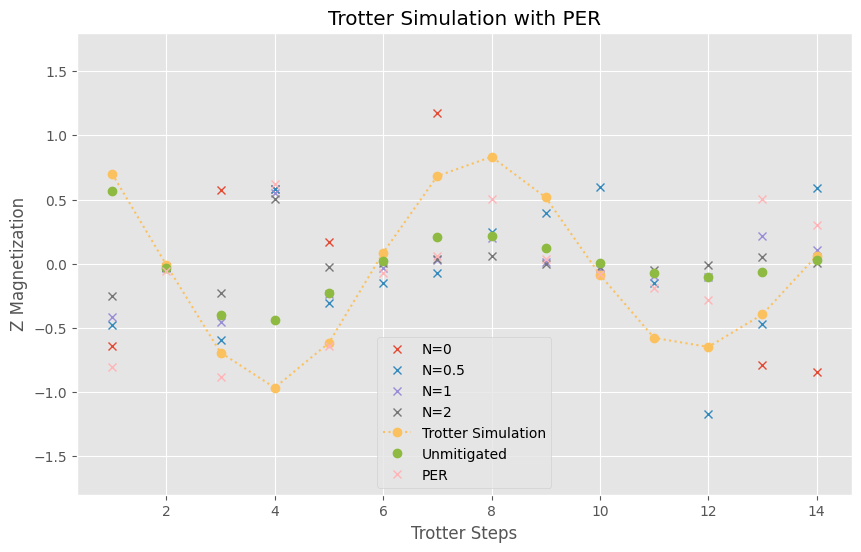

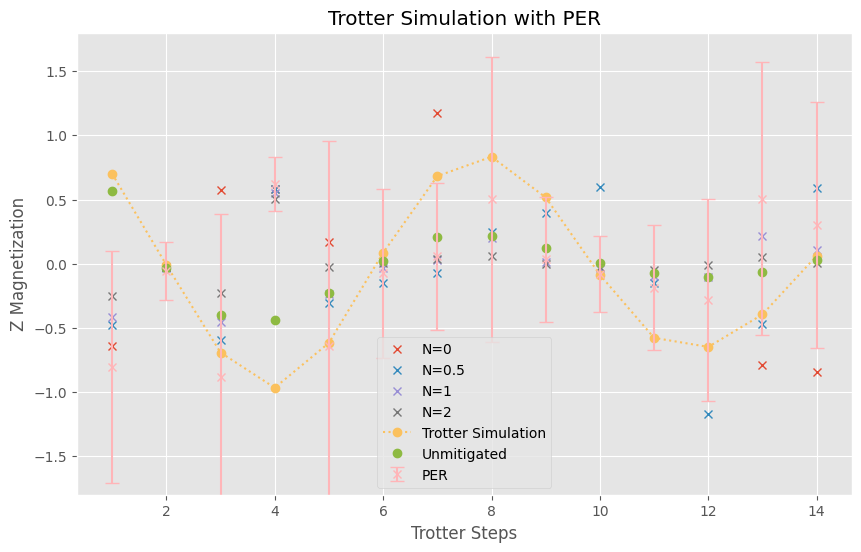

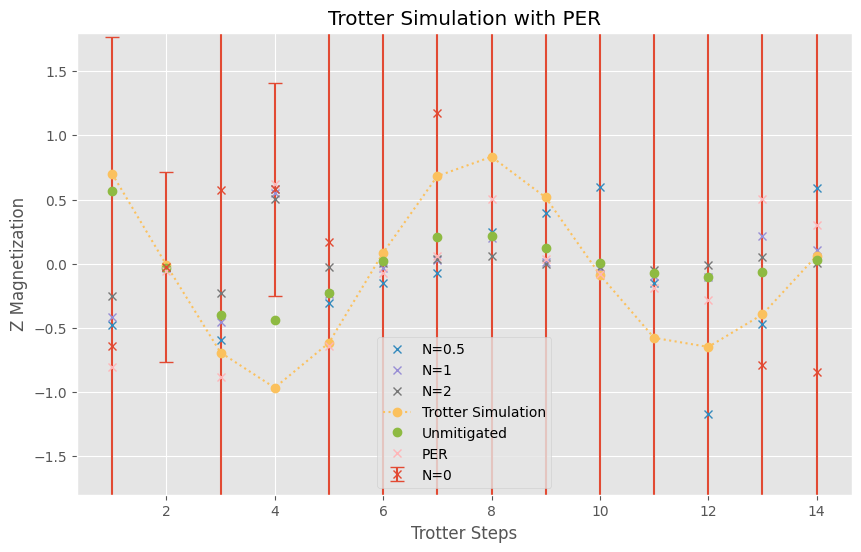

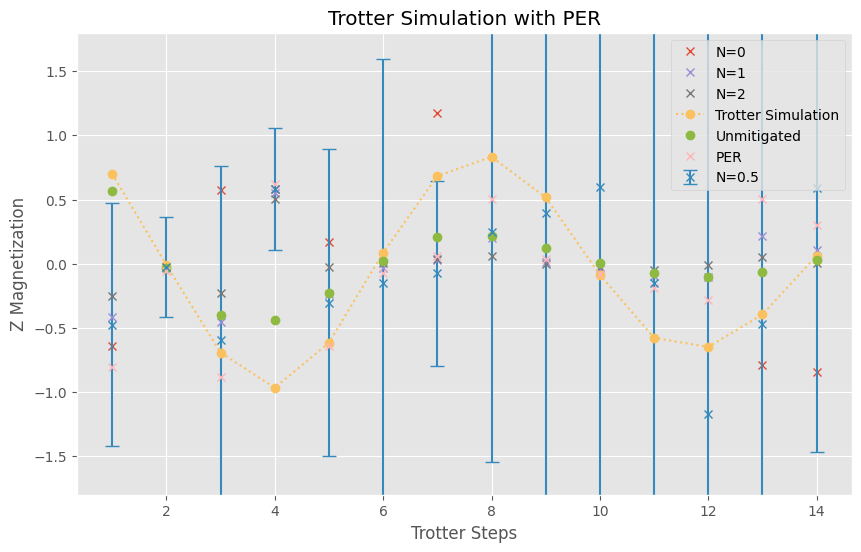

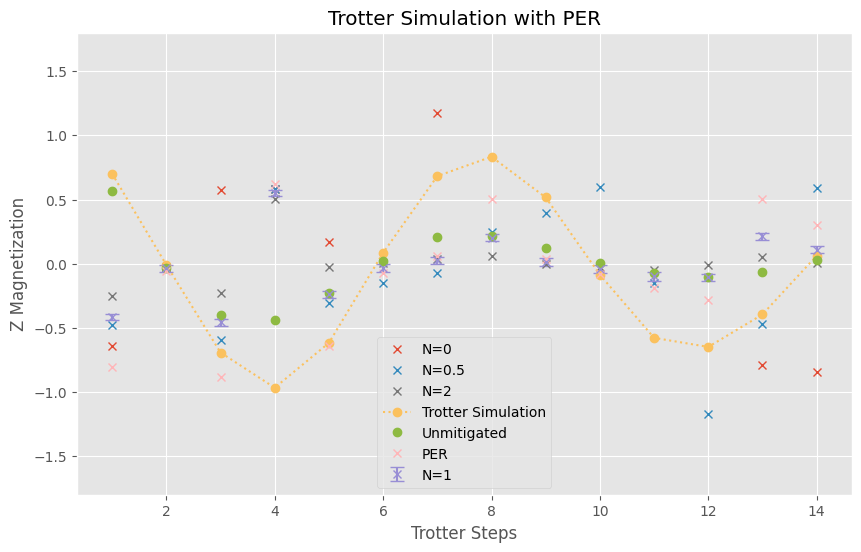

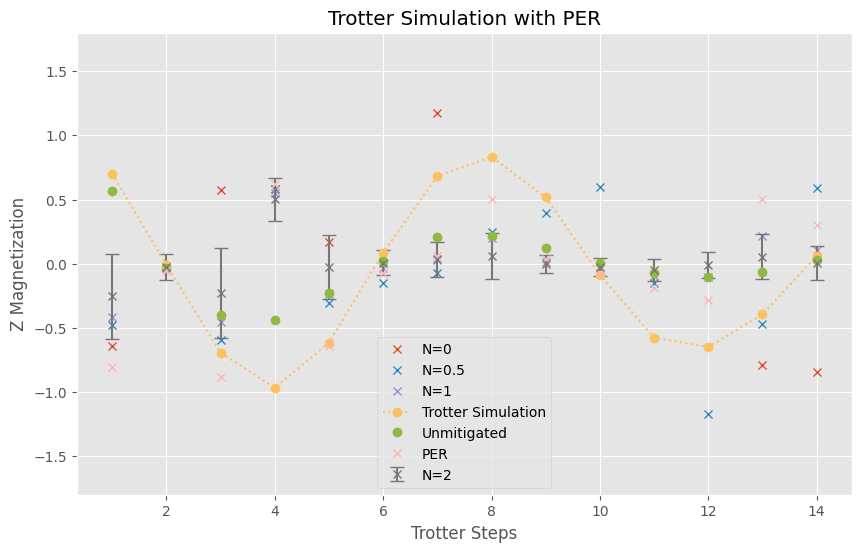

In [18]:
for j in range(len(noise_strengths)+2): # 0 vZNE results, 1-x results at noise level
	plt.figure(figsize=(10,6))
	for i, noise in enumerate(noise_strengths):
		if j != 0 and j!= 1 and noise == noise_strengths[j-2]:
			plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise))
		else:
			plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
		
	plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
	plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
	if j == 1:
		plt.errorbar(range(1,15), results, yerr=[[np.abs(res) for res in results_errors]],fmt='x', capsize=5, label="PER")
	else:
		plt.plot(range(1,15), results, 'x', label="PER")

	plt.ylim([-1.8,1.8])
	plt.legend()
	plt.title("Trotter Simulation with PER")
	plt.xlabel("Trotter Steps")
	plt.ylabel("Z Magnetization")
	#plt.savefig("Trotter_Sim_PER.png")
	plt.show()

In [19]:
ax = circuit_results[0].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.savefig("Expectation_vs_Noise_Strength_ZIII.png")
circuit_results[0].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
plt.savefig("Expectation_vs_Noise_Strength_IZII.png")
circuit_results[0].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
plt.savefig("Expectation_vs_Noise_Strength_IIZI.png")
circuit_results[0].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')
plt.savefig("Expectation_vs_Noise_Strength_IIIZ.png")

KeyError: ZIIII

## Analysis

In [ ]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

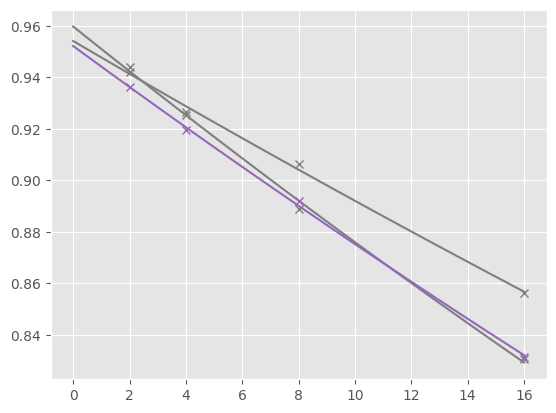

In [ ]:
layer1.graph((1,))

<Axes: >

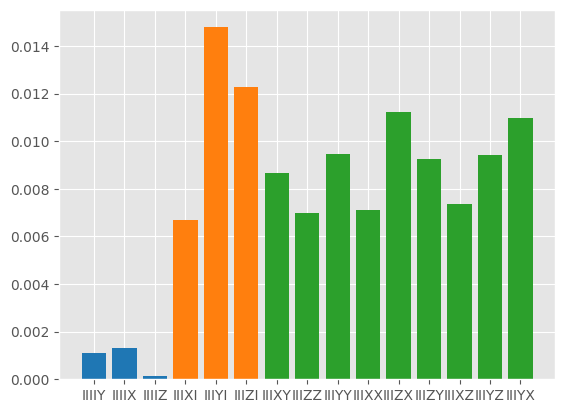

In [ ]:
layer1.plot_infidelitites((0,),(1,),(0,1))

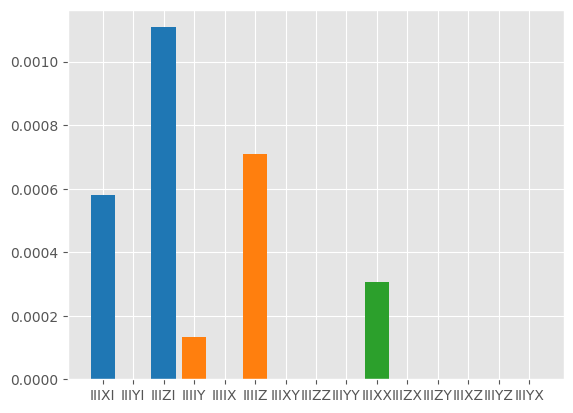

In [ ]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [ ]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)